# Metadata

```
Course:  DS 5001
Module:  03 Lab
Topic:   Demonstration of Simple Language Model
Author:  R.C. Alvarado
Date:    31 January 2023
```

**Purpose**: Demonstrates use of simple langauge model based on Berkeley restaurant data (from Jurafsky and Martin).

# Set Up

In [1]:
import pandas as pd
import numpy as np

# Make the Data

We convert these three tables into Pandas dataframes and use them to predict and generate sentences.

<img src="lm-data.png">

First, we create the table of unigrams and their frrequencies, i.e. the priors or marginals of a bigram model.

Note that this counts are relative to the entire corpus, not just the subset represented in the bigram table. So, we can't compute the probabilities of the unigrams.

In [2]:
data1 = dict(
    w0 = "i want to eat chinese food lunch spend".split(),
    n = [2533, 927, 2417, 746, 158, 1093, 341, 278]
)

In [3]:
df1 = pd.DataFrame(data1).set_index(['w0'])
df1.n = df1.n.astype('int')

Since we will want to use unigram probabilities for our model, we will estimate the number of tokens in the corpus. We will chose $50000$, based on the data found in [The Berkeley Restaurant Project (BeRP) Transcripts](https://github.com/wooters/berp-trans/). (We sum the counts in the `wordhist.txt` file and round down, since the data in the repo contain higher word counts for our words.)

In [4]:
C = 50000

In [5]:
df1['p'] = df1.n / C
df1['i'] = np.log2(1/df1.p)

In [6]:
df1

,n,p,i
w0,,,
i,2533,0.05066,4.303009
want,927,0.01854,5.753215
to,2417,0.04834,4.370639
eat,746,0.01492,6.066609
chinese,158,0.00316,8.305860
food,1093,0.02186,5.515563
lunch,341,0.00682,7.196013
spend,278,0.00556,7.490699


Next, we create a table joint probabilities that will be the basis for our bigram model.

In [7]:
data2 = [row.split(", ") for row in """
i, i, 5
i, want, 837
i, eat, 9
i, spend, 2
want, i, 2
want, to, 608
want, eat, 1
want, chinese, 6
want, food, 6
want, lunch, 5
want, spend, 1
to, i, 2
to, to, 4
to, eat, 686
to, chinese, 2
to, lunch, 6
to, spend, 211
eat, to, 2
eat, chinese, 16
eat, food, 2
eat, lunch, 42
chinese, i, 1
chinese, food, 82
chinese, lunch, 1
food, i, 15
food, to, 15
food, chinese, 1
food, food, 4
lunch, i, 2
lunch, food, 1
spend, i, 1
spend, to, 1
""".split("\n")[1:-1]]

In [8]:
df2 = pd.DataFrame(data2, columns = ['w0', 'w1', 'n']).set_index(['w0','w1'])
df2.n = df2.n.astype('int')

In [9]:
df2.sort_values('n', ascending=False)

n
w0      w1          
i       want     837
to      eat      686
want    to       608
to      spend    211
chinese food      82
eat     lunch     42
        chinese   16
food    to        15
        i         15
i       eat        9
want    chinese    6
        food       6
to      lunch      6
i       i          5
want    lunch      5
food    food       4
to      to         4
        chinese    2
        i          2
eat     to         2
        food       2
lunch   i          2
want    i          2
i       spend      2
spend   i          1
lunch   food       1
chinese lunch      1
food    chinese    1
want    eat        1
chinese i          1
want    spend      1
spend   to         1

Next, we compute conditional probabilities $p$ with the formula $p(B|A) = \large \frac{P(A,B)}{P(A)}$ converted to $\large \frac{C(A,B)}{C(A)}$.

We also compute the information $i$ for each $p$. This will allow use to compute perplexity $pp$ easily.

Note that information $i$ is just the negative of the log probability of the event, so we can use this to compute the log probability of sentences later.

In [10]:
df2['p'] = df2.n / df1.n
df2['i'] = np.log2(1/df2.p)

In [11]:
df2.sort_values('p', ascending=False).style.background_gradient(cmap='YlGnBu')

We convert a selection from the narrow table into a wide one, projecting the second index feature `w1` onto the second axis.

This is strictly not necessary, but it is convenient for certain computations and it is visually appealing.

In [12]:
df3 = df2.p.unstack(fill_value=0)

In [13]:
df3.style.background_gradient(cmap='YlGnBu', axis=None)

w1,chinese,eat,food,i,lunch,spend,to,want
w0,,,,,,,,
chinese,0.000000,0.000000,0.518987,0.006329,0.006329,0.000000,0.000000,0.000000
eat,0.021448,0.000000,0.002681,0.000000,0.056300,0.000000,0.002681,0.000000
food,0.000915,0.000000,0.003660,0.013724,0.000000,0.000000,0.013724,0.000000
i,0.000000,0.003553,0.000000,0.001974,0.000000,0.000790,0.000000,0.330438
lunch,0.000000,0.000000,0.002933,0.005865,0.000000,0.000000,0.000000,0.000000
spend,0.000000,0.000000,0.000000,0.003597,0.000000,0.000000,0.003597,0.000000
to,0.000827,0.283823,0.000000,0.000827,0.002482,0.087298,0.001655,0.000000
want,0.006472,0.001079,0.006472,0.002157,0.005394,0.001079,0.655879,0.000000


# Apply the Model

Now we generate sentences from the model and also compute their probabilities and perplexities.

We also demonstrate the relationship between sum of log probability, mean information, and perplexity.

In [14]:
N = 20
M = 10
results = []

# Generate N sentences
for i in range(N):
    
    # Get a start word from the unigram list (since we don't have sentence boundaries in our bigram model
    start = df1.sample(weights='n')
    w0 = start.index[0]
    i = start.i.values[0] # This is why we needed to estimate the number of tokens in the corpus C
    
    # Initialize sentence feature lists
    W = [w0]
    I = [i]
    LP = [-i]
    
    # Select M words for each sentence
    for j in range(M-1):
        w1 = df3.loc[w0].sample(weights=df3.loc[w0].values).index[0]
        i = df2.loc[(w0, w1), 'i']
        W.append(w1)
        I.append(i)
        LP.append(-i)
        w0 = w1

    # Compute sentence stats
    S = pd.DataFrame(dict(w=W, i=I, lp=LP)) # This is expensive; we'd do it differently at scale
    i_mean = S.i.mean()
    lp_sum = S.lp.sum()
    pp = 2**(i_mean)
    sent_str = ' '.join(W)
    
    # Append to results 
    results.append((sent_str, lp_sum, i_mean, pp))
    
# Put results in a dataframe
R = pd.DataFrame(results, columns=['sentence', 'logprob', 'i_mean', 'pp'])

# Keep only unique sentences, i.e. treat sentences as index values
sentence_counts = R.sentence.value_counts().to_frame('n')
R = R.drop_duplicates()
R = R.reset_index(drop=True).set_index('sentence')
R['n'] = sentence_counts

# Display results
R.sort_values('i_mean', ascending=True).style.background_gradient(cmap="YlGnBu")

,logprob,i_mean,pp,n
sentence,,,,
i want to eat lunch i want to eat lunch,-28.064031,2.806403,6.995383,3
i want to spend i want to spend i want,-33.586335,3.358634,10.257687,1
i want to spend to eat lunch i want to,-33.733223,3.373322,10.362659,1
to spend i want to eat lunch i want to,-33.800853,3.380085,10.411350,2
i want to eat chinese food to spend i want,-34.236831,3.423683,10.730780,2
to eat chinese food i want to spend i want,-34.304460,3.430446,10.781201,1
to spend to eat chinese food i want to eat,-34.523850,3.452385,10.946403,1
want to spend to eat lunch i want to eat,-35.402818,3.540282,11.634053,1
to spend to spend i want to eat chinese food,-38.156569,3.815657,14.080795,1


# Interpet Results

Compare mean `i` to the sum of log `p`. Notice they are identical when normalized by mean.

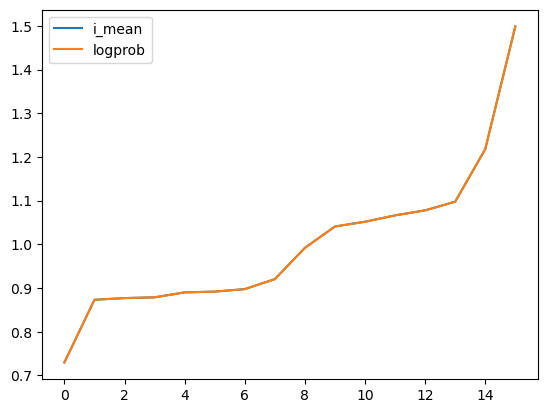

In [15]:
(R / R.mean()).sort_values('i_mean')[['i_mean','logprob']].reset_index().plot();

Compre perplexity `pp` to mean information `i`. Notice how perplexity amplifies the difference.

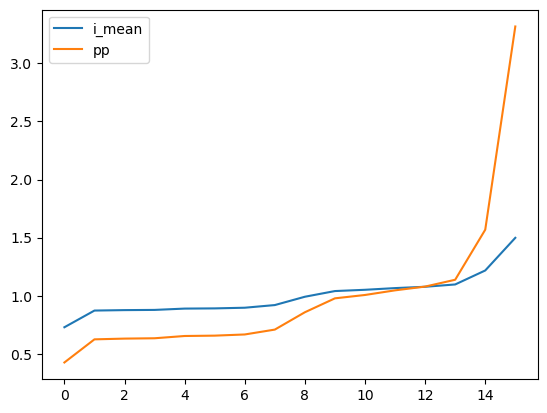

In [16]:
(R / R.mean()).sort_values('i_mean')[['i_mean','pp']].reset_index().plot();

So, we will use perplexity to measure of how well a model performs.

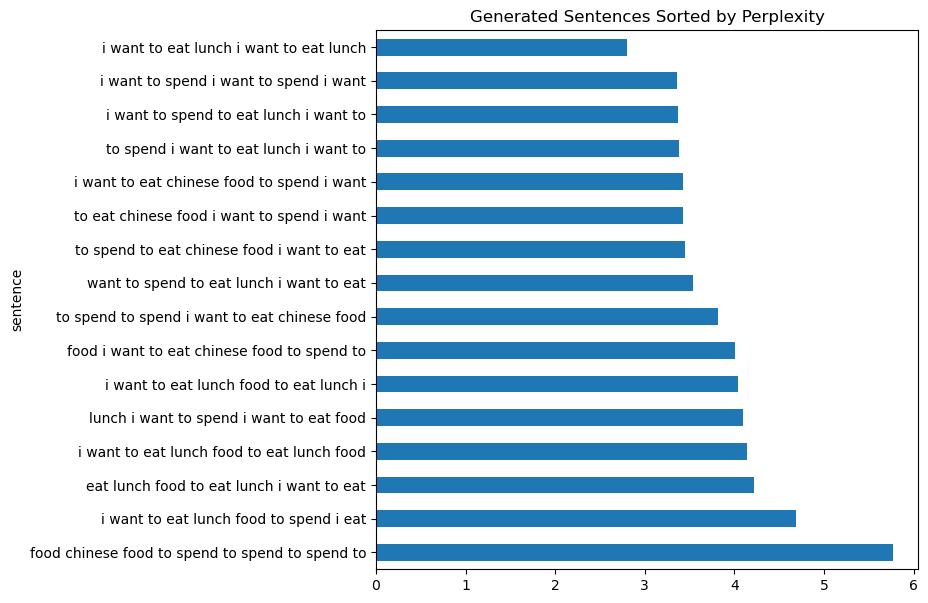

In [17]:
R.reset_index().set_index('sentence').sort_values('pp').i_mean.sort_values(ascending=False)\
    .plot.barh(figsize=(7,7), title="Generated Sentences Sorted by Perplexity");

Since perplexity looks something like squaring the error of our model (where mean information is interpreted as error), let's create a test feature that just squares mean information and compare to the other features.

In [19]:
R['test'] = R.i_mean**2

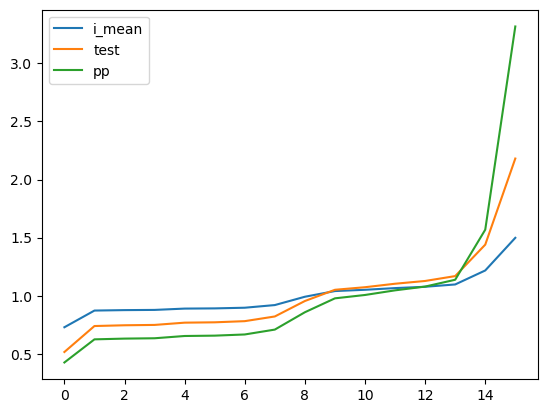

In [22]:
(R / R.mean()).sort_values('i_mean')[['i_mean', 'test','pp']].reset_index().plot();